# Preparations

In [15]:
import ast
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (10,8)

In [16]:
# Some parameters of the simulations to be analyzed
rounds = 50
vehicle_limit = 80

target_number_of_rounds = 15

all_routes = [[0, 3], [0, 1], [2, 3], [2, 1]]
sub_routes = [[0, 1], [2, 3]]

In [17]:
rate_folders = ["2.1 Vehicle rate = 22", "2.2 Vehicle rate = 27", "2.3 Vehicle rate = 45"]

In [18]:
scenario_names = [".2 Lower eta", ".3 Higher eta", ".1 Avg scenario", 
                 ".4 Lower gamma", ".5 Higher gamma"]

case_names = [".2 No connection", ".1 Zero alpha", ".4 Small alpha", 
              ".3 Avg alpha", ".5 Large alpha"]

## Preprocessing of `record`
The dataframe contains vehicle data recorded in each simulation round, including:
- the label assigned to each car (`Vehicle_label`)
- the routes taken (`Road_order`)
- the time spent to reach the end (`Total_time`)
- the label of the vehicle immediately in front of it in the corrdsponding road segment (`Leading_vehicles`)
- the amount of time it stopped (speed is 0) in the corresponding road segment (`Stopped_time`)

In [19]:
def preprocess_record(record, routes):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    record['Road_order'] = record.apply(lambda row: ast.literal_eval(row['Road_order']), axis=1)

    # Add a column that maps a specific road combination (i.e., a route) to a "label", which is its position
    # in a list that shows all the possible routes
    record["Road_order_label"] = record.apply(lambda row: routes.index(row.Road_order), axis=1)
    return record

## Preprocessing of `utility`
The dataframe contains utility data computed based on the simulation outcome, including:
- the label assigned to each car (`Vehicle_label`)
- the utility value of each route as a list element (`Utilities`)
- the probability value of choosing each route in the next round as a list element (`Probabilities`)
- all the routes each car has chosen so far (`Routes_taken`)
- the interpolation between time and money for the driver (`Gamma`) for computing the time component of the utility value
- the risk aversion level of the driver (`Eta`) for deciding the formula of utility calculation

In [20]:
def preprocess_utility(utility):
    # Since some column values are lists, they need to be preprocessed after importing the csv file to
    # avoid the lists being recognized as strings
    utility['Routes_taken'] = utility.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
    utility['Probabilities'] = utility.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
    return utility

## Functions needed

In [21]:
def avg_total_time(df, target_number_of_rounds, rounds):
    """
    Computes the average total time spent by all vehicles per round for 
    the last n rounds. (n is specified in the function input)
    
    Parameters:
        df (pd.DataFrame): dataframe that records vehicle-specific data of all
                           rounds in a simulation run
        target_number_of_rounds (integer): how many rounds to be considered in
                                           the average time calculation
        rounds (integer): total number of rounds
    """
    
    pivot_df = pd.pivot_table(df, values='Total_time', 
                              index='Round_number', 
                              aggfunc=np.sum).reset_index(drop=False)
    return pivot_df.loc[pivot_df.Round_number>(rounds-target_number_of_rounds)].Total_time.mean()

In [22]:
def route_avg_time(ax, 
                   fig,
                   record_df, 
                   number_of_routes):
    """
    Plot the average time to arrive grouped by each route and round.
    """
    
    time_df = pd.pivot_table(record_df, values='Total_time', 
                             index=['Road_order_label', 'Round_number'], 
                             aggfunc=np.mean).reset_index(drop=False)
    plot_route_time = [[], [], [], []]

    for i in range(number_of_routes):
        times = time_df.loc[time_df.Road_order_label==i].sort_values('Round_number').Total_time.values
        plot_route_time[i]=times

    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_route_time[i], color=colors[i])

    ax.set_xlabel("Round")
    ax.set_ylabel("Average time to arrive (s)")
 
    return ax

In [23]:
def route_taken_number(ax,
                       fig,
                       utility_df, 
                       rounds, 
                       number_of_routes):
    """
    Plot the changes in number of vehicles that took the route over time.
    """
    
    route_df = pd.DataFrame(utility_df['Routes_taken'].to_list(), columns=range(rounds))
    plot_route_l = [[], [], [], []]

    for i in range(number_of_routes):
        for j in range(rounds):
            plot_route_l[i].append(len(route_df.loc[route_df[j]==i]))

    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_route_l[i], color=colors[i])
    
    ax.set_xlabel("Round")
    ax.set_ylabel("Number of vehicles")
    
    return ax

In [24]:
def route_chosen_probability(ax,
                             fig,
                             rounds, 
                             number_of_routes,
                             folder_name):
    """
    Plot the changes in probabilities of choosing each route over time.    
    """
    
    plot_prob_l = [[], [], [], []]

    for r in range(1, rounds+1):
        df = pd.read_csv(f'{folder_name}/Saved_data/Utility_data/Round_{r}.csv')
        df['Probabilities'] = df.apply(lambda row: ast.literal_eval(row['Probabilities']), axis=1)
        
        for i in range(number_of_routes):
            avg_prob = pd.DataFrame(df['Probabilities'].to_list(), columns=range(number_of_routes))[i].mean()
            plot_prob_l[i].append(avg_prob)
            
    if number_of_routes == 2:
        colors = ['tab:red', 'tab:green']
    else:
        colors = ['tab:orange', 'tab:red', 'tab:green', 'tab:blue']
        
    for i in range(number_of_routes):
        ax.plot(plot_prob_l[i], color=colors[i])

    ax.set_xlabel("Round")
    ax.set_ylabel("Average probability")
    
    return ax

In [25]:
def total_utility(target_number_of_rounds, 
                  rounds,
                  folder_name,
                  save_dir=None):
    
    """
    Plot and return the total utility values of all vehicles in each of the last few rounds.
    The number of rounds is specified by 'target_number_of_rounds'.
    """
    
    total_utilities = np.zeros((target_number_of_rounds))
    
    for r in range(rounds-target_number_of_rounds+1, rounds+1):
        df = pd.read_csv(f'{folder_name}/Saved_data/Utility_data/{rate}/Round_{r}.csv')
        df['Utilities'] = df.apply(lambda row: ast.literal_eval(row['Utilities']), axis=1)
        df['Routes_taken'] = df.apply(lambda row: ast.literal_eval(row['Routes_taken']), axis=1)
        
        for idx, row in df.iterrows():
            route_taken = row['Routes_taken'][-1]
            utility = row['Utilities'][route_taken]
            
            total_utilities[r-(rounds-target_number_of_rounds+1)] += utility
    return total_utilities

# Visualization

In [26]:
def get_subfolders(case_name, rate_folders):
    subfolder_names = []
    for rf in rate_folders:
        current_hier = rf.split(" ")[0]
        for scenario_name in scenario_names:
            folder_name = rf + "/" + current_hier + scenario_name
            subfolder_names.append(folder_name+"/"+folder_name.split("/")[-1][:5]+case_name)
            
            folder_name = rf + "/" + current_hier + scenario_name
    
    return subfolder_names

In [27]:
row, col = 3, 5
width, height = 20, 10

## - The average time needed to reach destination by different routes

In [28]:
# subfolder_names = get_subfolders(case, rate_folders)
# len(subfolder_names)
# # subfolder_names

In [29]:
def avg_time_by_case(case_name):
    
    global rate_folders
    global row
    global col
    global width
    global height
    
    subfolder_names = get_subfolders(case_name, rate_folders)
    
    fig, axs = plt.subplots(row, col, figsize=(width, height))

    for idx in range(len(subfolder_names)):
        folder = subfolder_names[idx]
        record_df = pd.read_csv(f'{folder}/Saved_data/Simulation_records/Round_{rounds}.csv')
        record_df = preprocess_record(record_df, all_routes)

        ax = route_avg_time(axs[idx//col, idx%col], 
                            fig,
                            record_df=record_df, 
                            number_of_routes=len(all_routes)
                           )
        axs[idx//col, idx%col] = ax

    plt.tight_layout()

    plt.savefig(f"Analysis/Avg_time_by_route_{case_name[3:].replace(' ', '_')}.png",
                bbox_inches = 'tight', pad_inches=0.25)
    
    print(f"Visualization of average time by route for {case_name[3:]}:")
    plt.show()

## - The number of vehicles that choose a route over time

In [30]:
def vehicle_num_by_case(case_name):
    
    global rate_folders
    global row
    global col
    global width
    global height
    
    subfolder_names = get_subfolders(case_name, rate_folders)
    
    fig, axs = plt.subplots(row, col, figsize=(width, height))

    for idx in range(len(subfolder_names)):
        folder = subfolder_names[idx]
        utility_df = pd.read_csv(f'{folder}/Saved_data/Utility_data/Round_{rounds}.csv')
        utility_df = preprocess_utility(utility_df)

        if "No connection" in folder:
            ax = route_taken_number(axs[idx//col, idx%col], 
                                fig,
                                utility_df,
                                rounds, 
                                len(sub_routes)
                               )
        else:
            ax = route_taken_number(axs[idx//col, idx%col], 
                                fig,
                                utility_df,
                                rounds, 
                                len(all_routes)
                               )

        axs[idx//col, idx%col] = ax

    plt.tight_layout()

    plt.savefig(f"Analysis/Vehicle_number_by_route_{case_name[3:].replace(' ', '_')}.png",
                bbox_inches = 'tight', pad_inches=0.25)
    
    print(f"Visualization of Vehicle number by route for {case_name[3:]}:")
    plt.show()

## - The probabilities of choosing different routes over time

In [31]:
def avg_prob_by_case(case_name):
    
    global rate_folders
    global row
    global col
    global width
    global height
    
    subfolder_names = get_subfolders(case_name, rate_folders)
    
    fig, axs = plt.subplots(row, col, figsize=(width, height))

    for idx in range(len(subfolder_names)):
        folder = subfolder_names[idx]

        if "No connection" in folder:
            ax = route_chosen_probability(axs[idx//col, idx%col], 
                                          fig,
                                          rounds,
                                          len(sub_routes),
                                          folder
                                         )
        else:
            ax = route_chosen_probability(axs[idx//col, idx%col], 
                                          fig,
                                          rounds,
                                          len(all_routes),
                                          folder
                                         )


        axs[idx//col, idx%col] = ax

    plt.tight_layout()
    plt.savefig(f"Analysis/Average_probability_by_route_{case_name[3:].replace(' ', '_')}.png",
                bbox_inches = 'tight', pad_inches=0.25)
    print(f"Visualization of Average probability by route for {case_name[3:]}:")
    plt.show()

In [32]:
# for rf in rate_folders:
#     current_hier = rf.split(" ")[0]

#     folder_names = [current_hier+".1 Avg scenario", current_hier+".2 Lower eta", 
#                     current_hier+".3 Higher eta", current_hier+".4 Lower gamma",
#                     current_hier+".5 Higher gamma"]
# subfolder_names = []
# for f in folder_names:
#     subfolder_names.extend([f+"/"+f[:5]+".2 No connection", f+"/"+f[:5]+".1 Zero alpha",
#                             f+"/"+f[:5]+".3 Avg alpha", f+"/"+f[:5]+".4 Small alpha",
#                             f+"/"+f[:5]+".5 Large alpha"])

In [33]:
# scenario = scenario_names[0]
# subfolder_names = folder_names_by_scenario(scenario, rate_folders)
# subfolder_names

In [34]:
# print(f"Visualization of average time by route for {scenario[3:]}:")
# subfolder_names = folder_names_by_scenario(scenario, rate_folders)

# fig, axs = plt.subplots(row, col, figsize=(width, height))

# for idx in range(len(subfolder_names)):
#     folder = subfolder_names[idx]
#     record_df = pd.read_csv(f'{folder}/Saved_data/Simulation_records/Round_{rounds}.csv')
#     record_df = preprocess_record(record_df, all_routes)

#     ax = route_avg_time(axs[idx//col, idx%col], 
#                         fig,
#                         record_df=record_df, 
#                         number_of_routes=len(all_routes)
#                        )
#     axs[idx//col, idx%col] = ax
    
# plt.tight_layout()

# plt.savefig("Analysis/Avg_time_by_route_avg_scenario.png",
#             bbox_inches = 'tight', pad_inches=0.25)
# plt.show()

### 1. No connection

Visualization of average time by route for No connection:


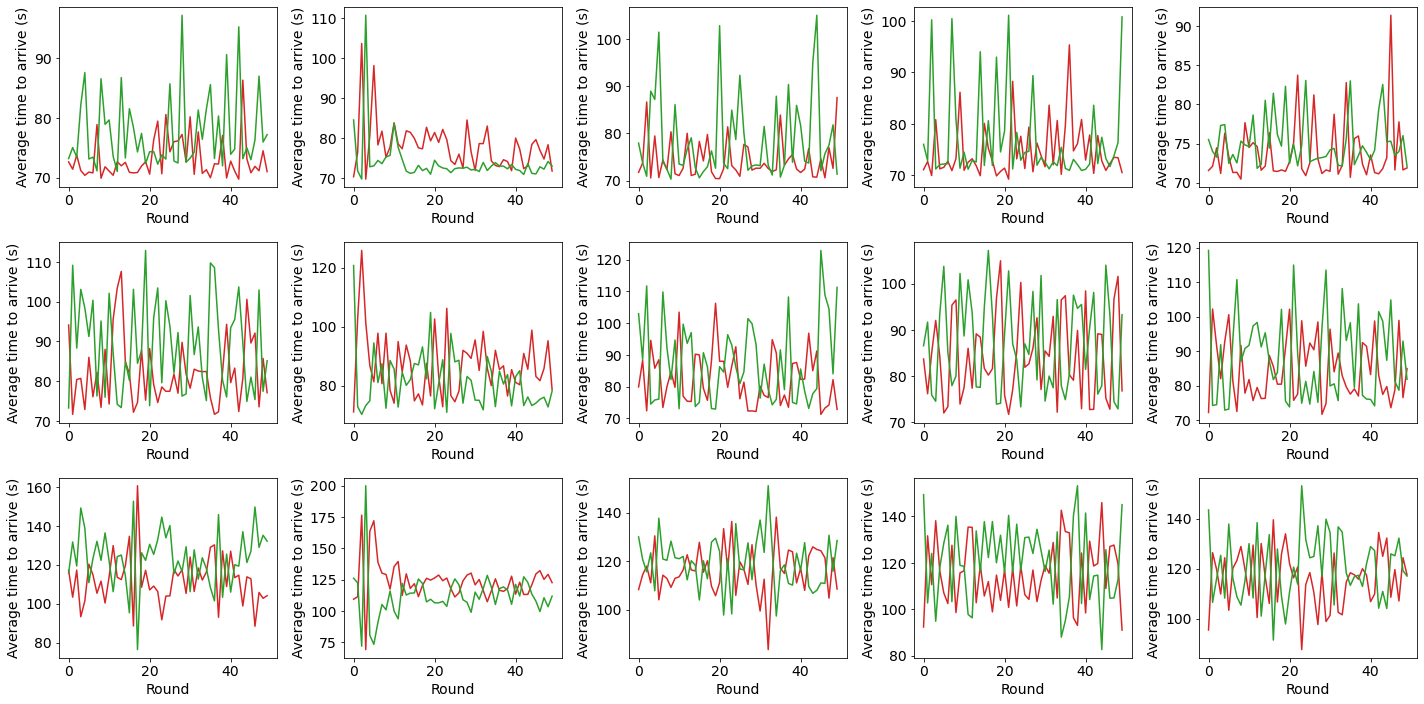

Visualization of Vehicle number by route for No connection:


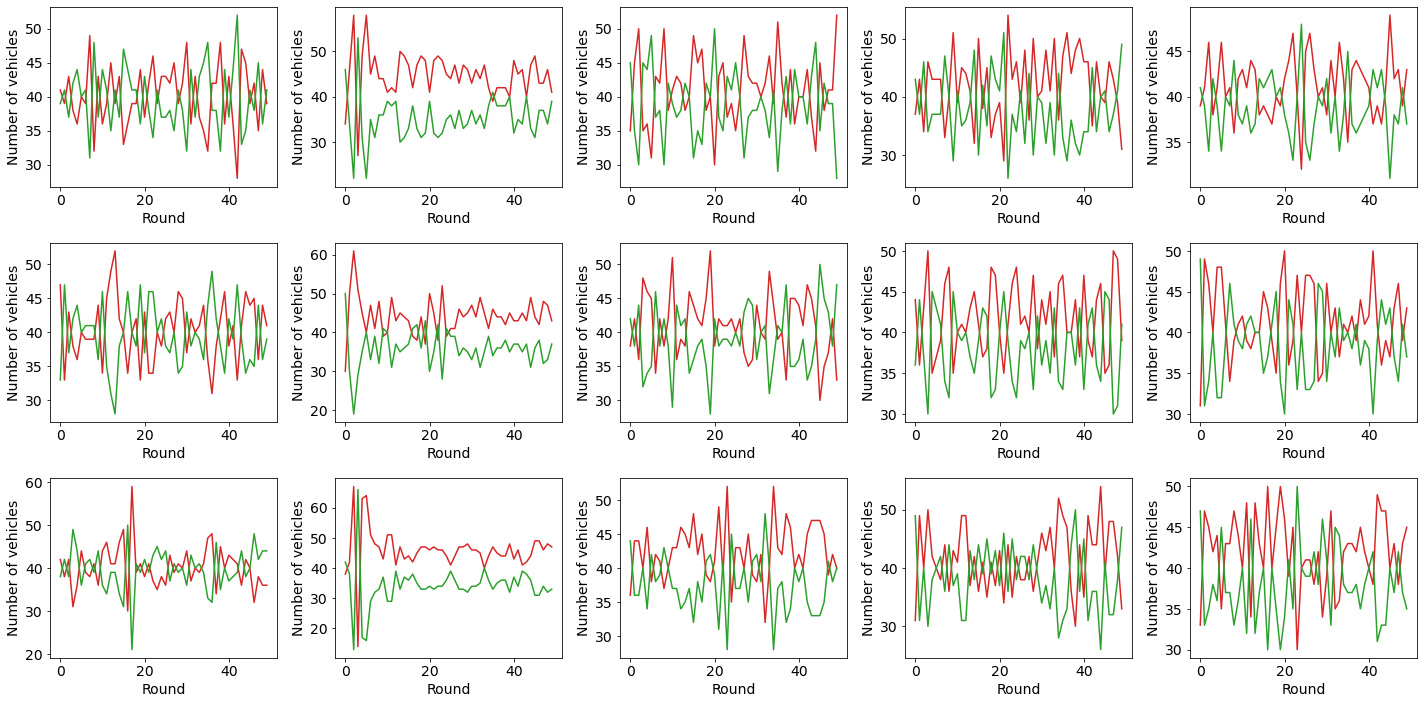

Visualization of Average probability by route for No connection:


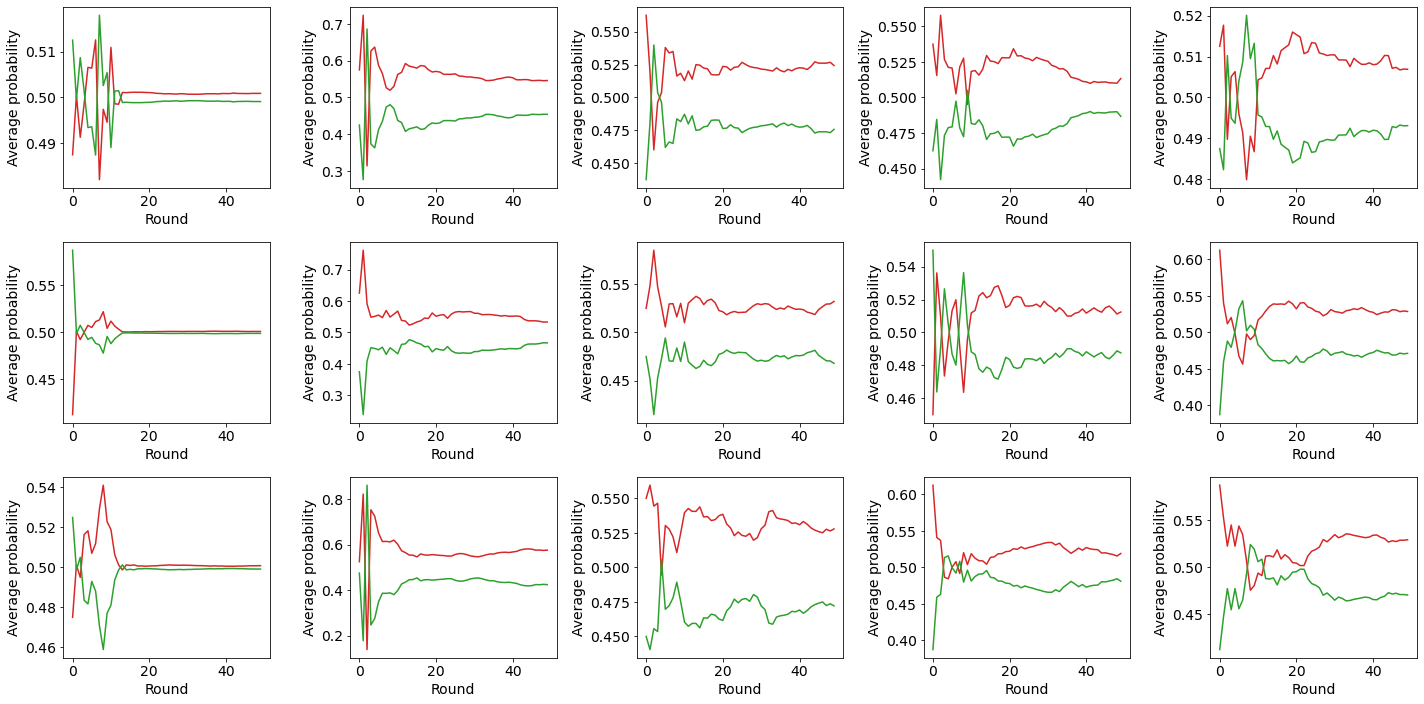

In [35]:
case = case_names[0]
avg_time_by_case(case)
vehicle_num_by_case(case)
avg_prob_by_case(case)

### 2. Zero alpha

Visualization of average time by route for Zero alpha:


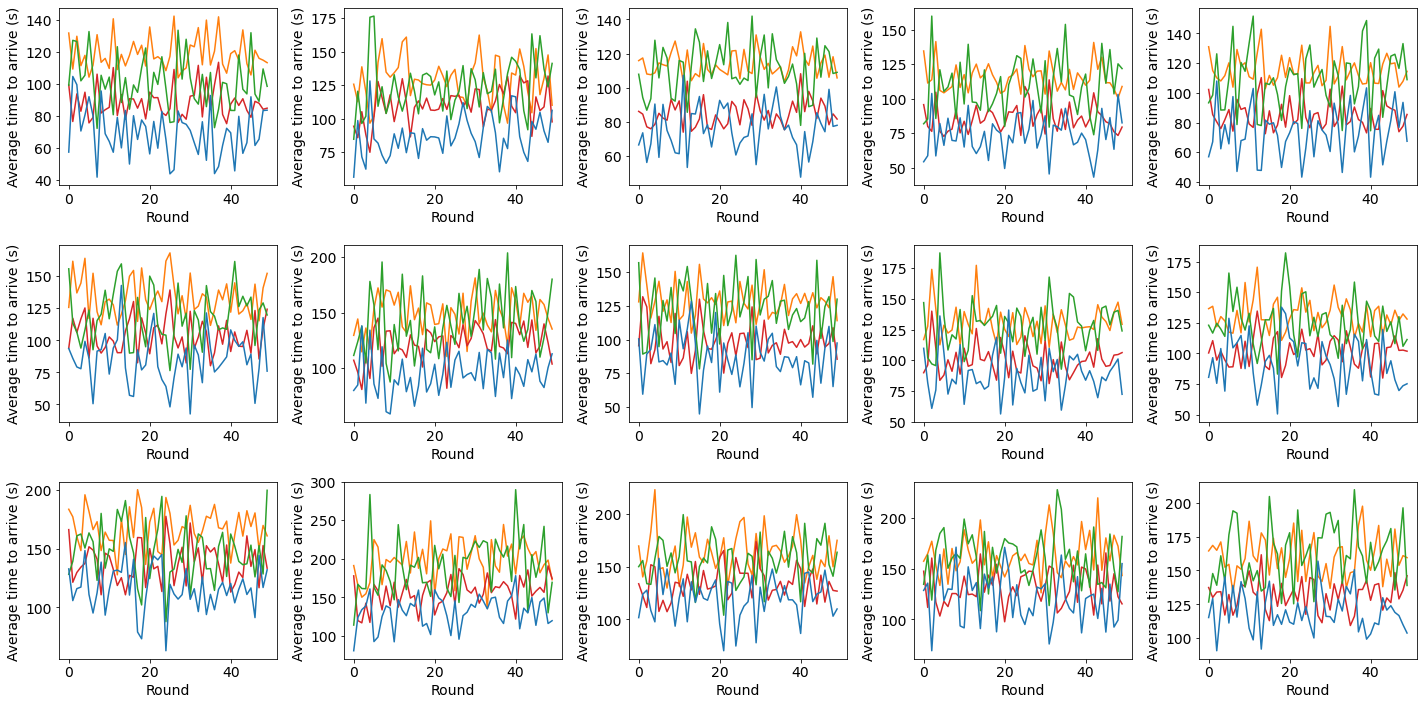

Visualization of Vehicle number by route for Zero alpha:


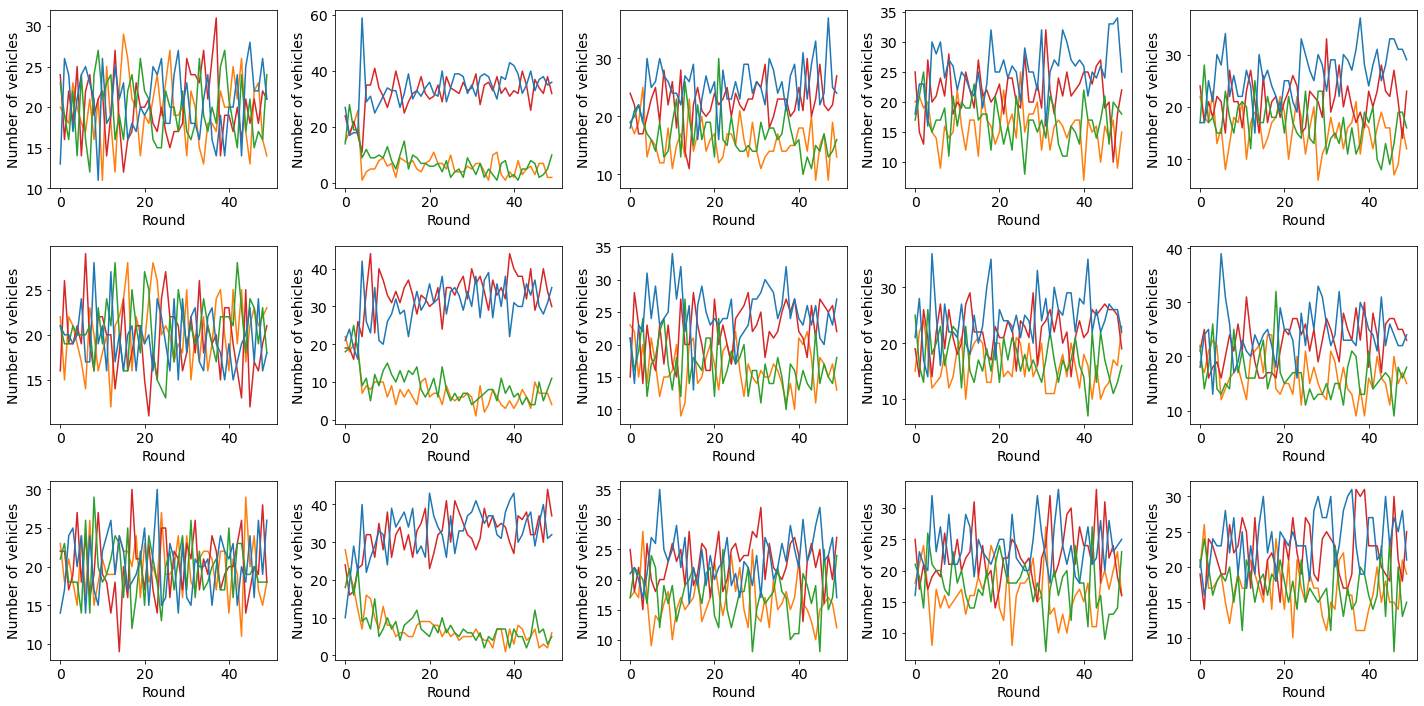

Visualization of Average probability by route for Zero alpha:


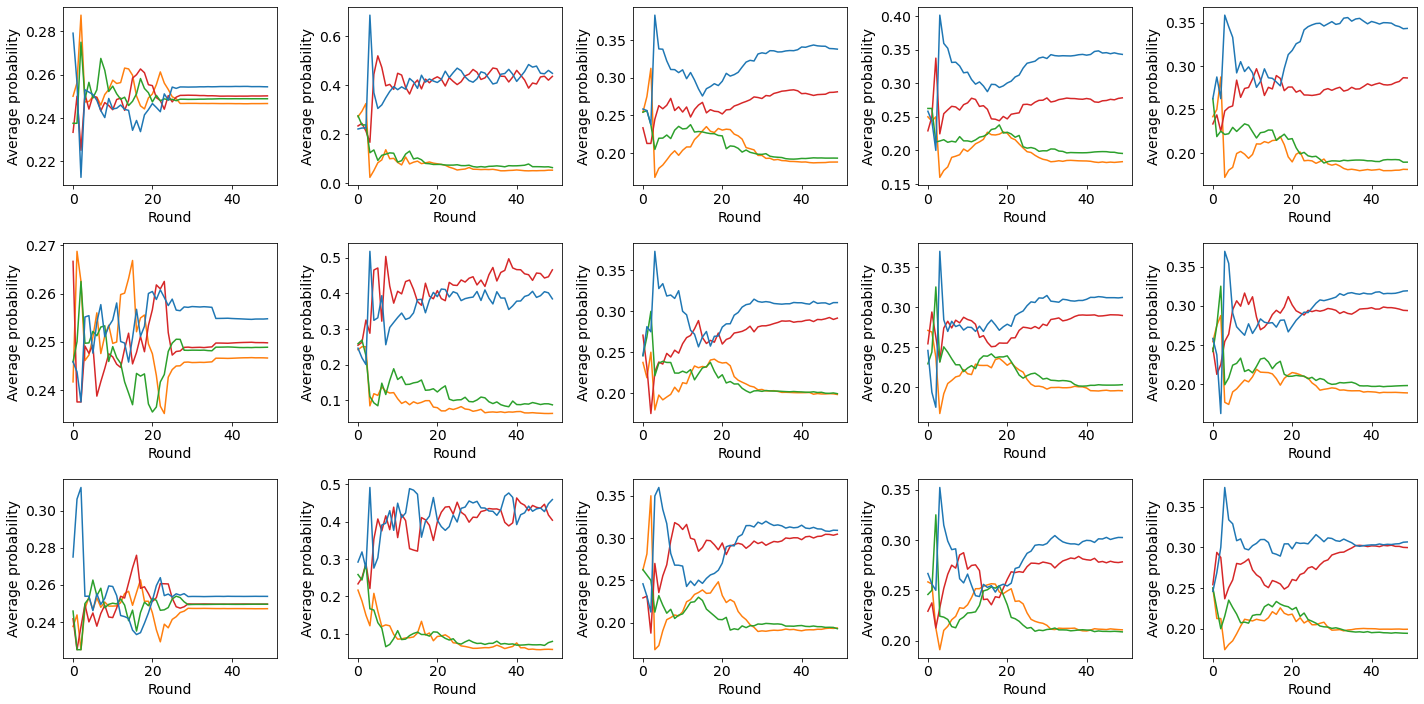

In [36]:
case = case_names[1]
avg_time_by_case(case)
vehicle_num_by_case(case)
avg_prob_by_case(case)

### 3. Avg alpha

Visualization of average time by route for Small alpha:


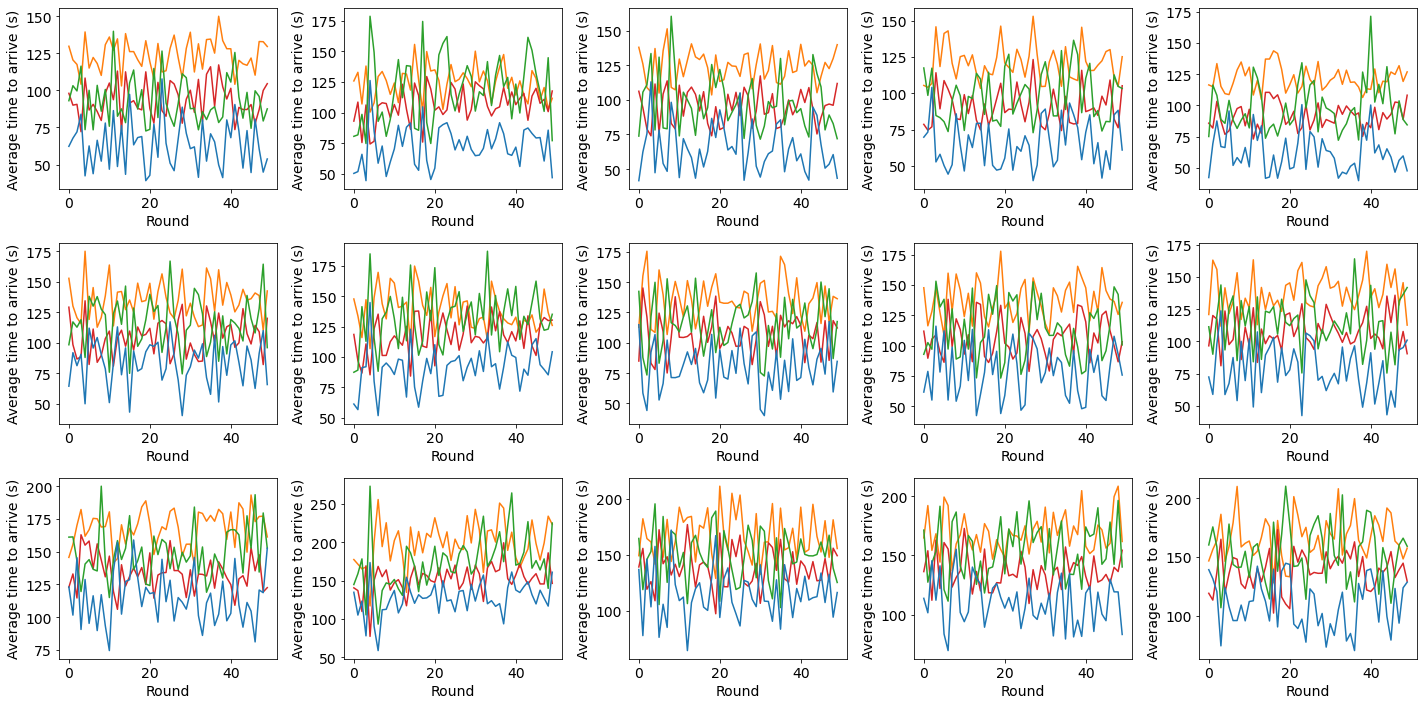

Visualization of Vehicle number by route for Small alpha:


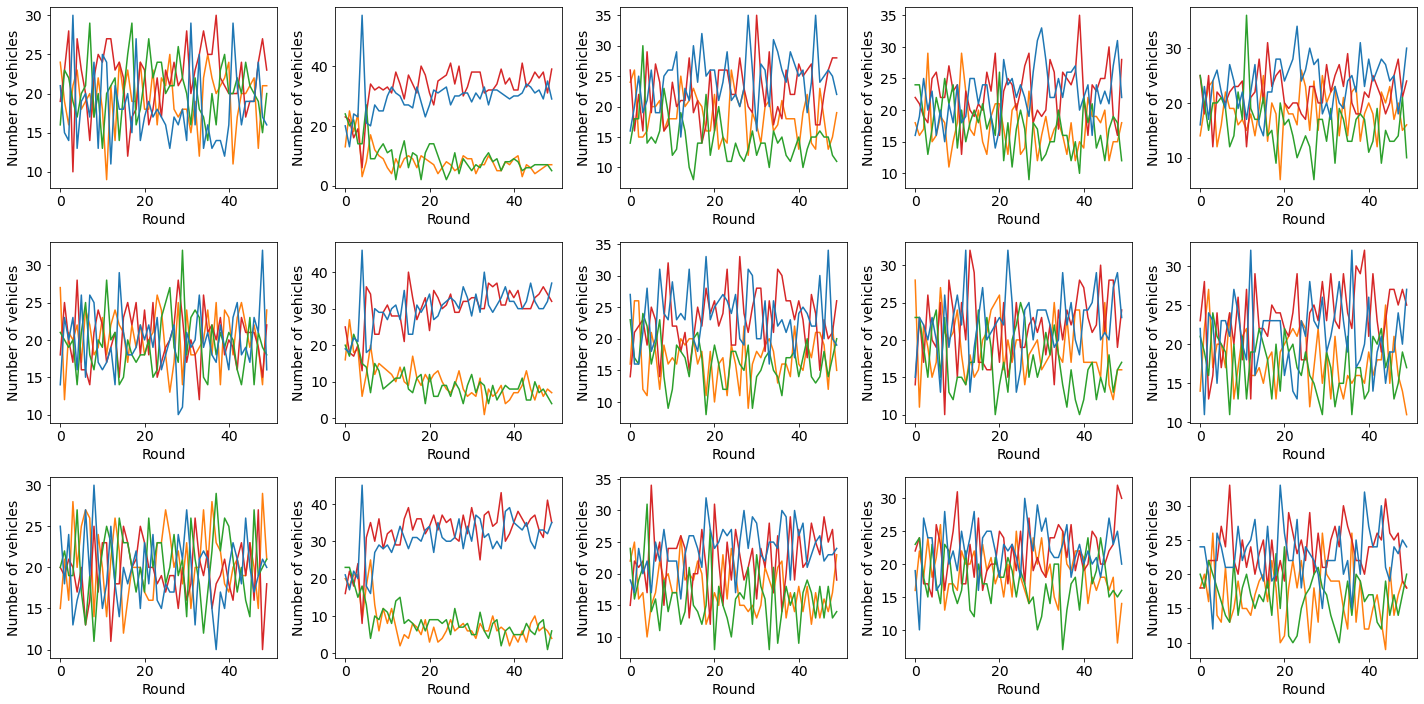

Visualization of Average probability by route for Small alpha:


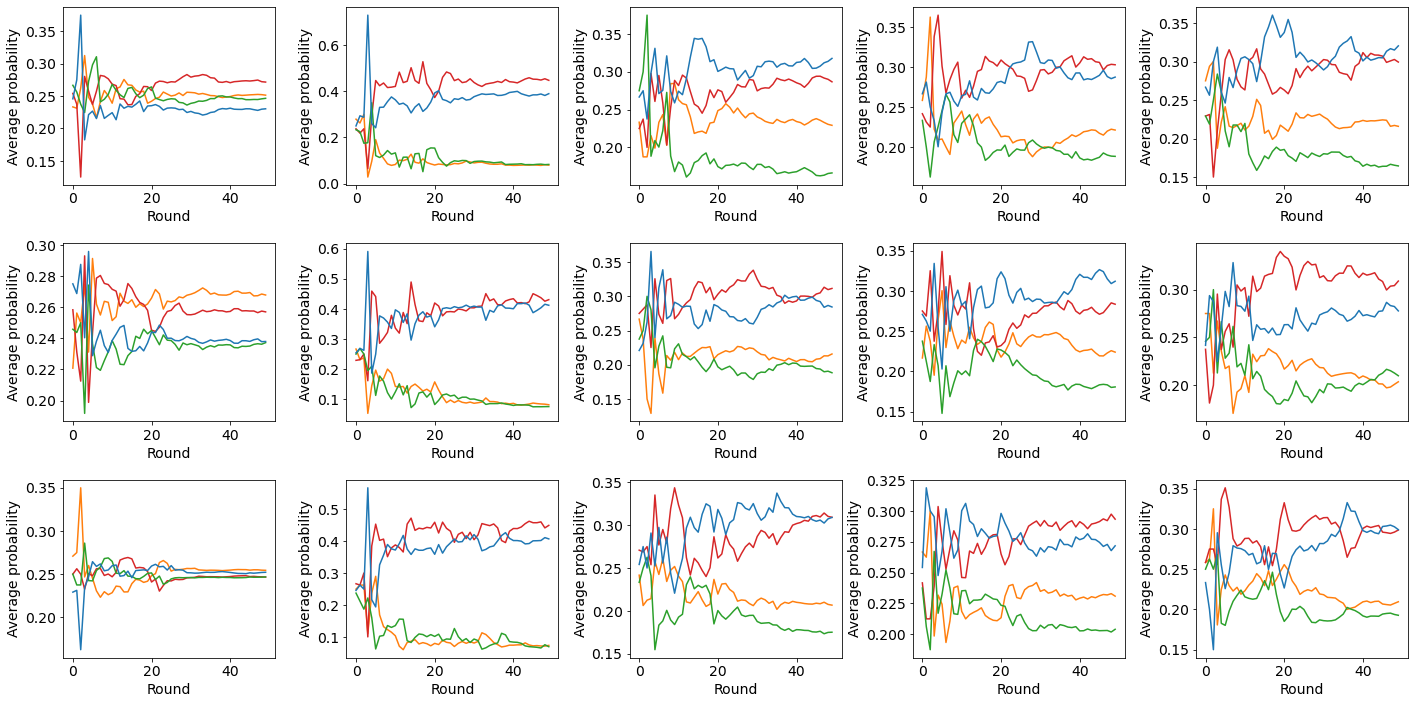

In [37]:
case = case_names[2]
avg_time_by_case(case)
vehicle_num_by_case(case)
avg_prob_by_case(case)

### 4. Small alpha

Visualization of average time by route for Avg alpha:


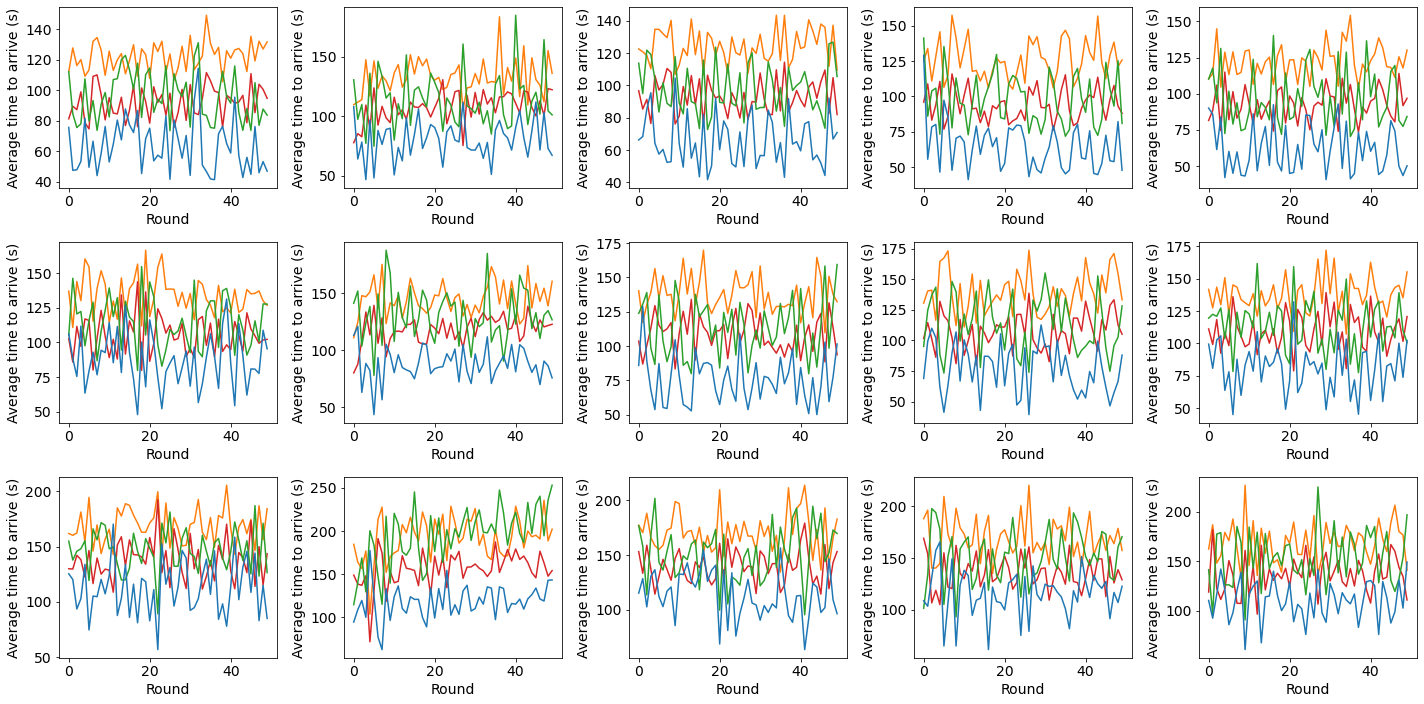

Visualization of Vehicle number by route for Avg alpha:


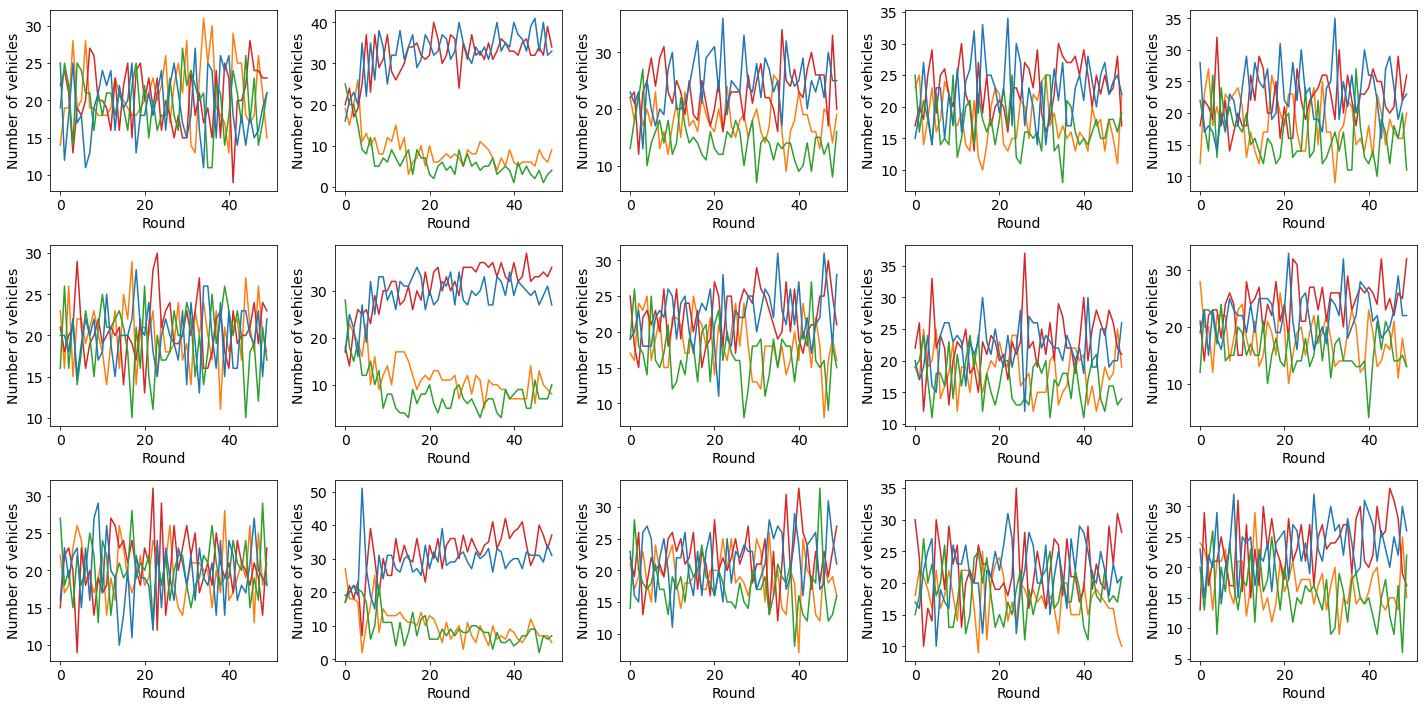

Visualization of Average probability by route for Avg alpha:


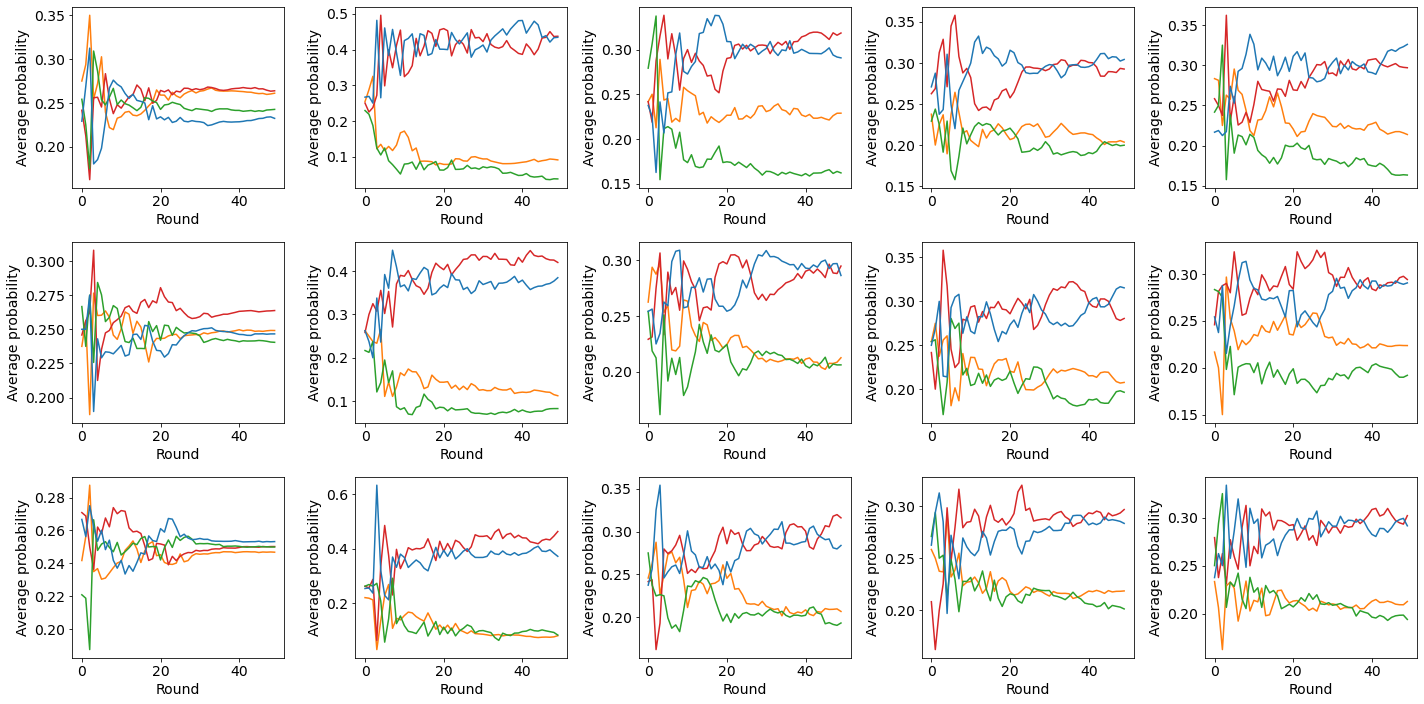

In [38]:
case = case_names[3]
avg_time_by_case(case)
vehicle_num_by_case(case)
avg_prob_by_case(case)

### 5. Large alpha

Visualization of average time by route for Large alpha:


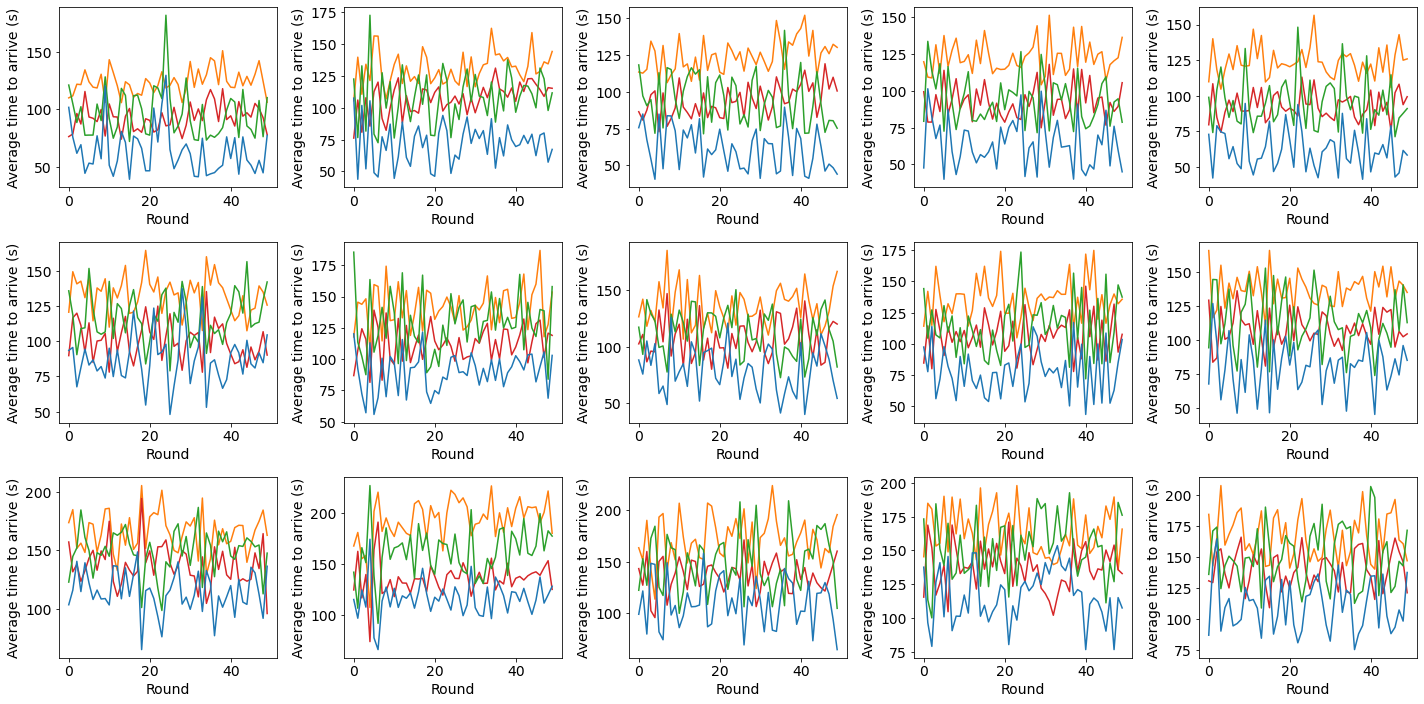

Visualization of Vehicle number by route for Large alpha:


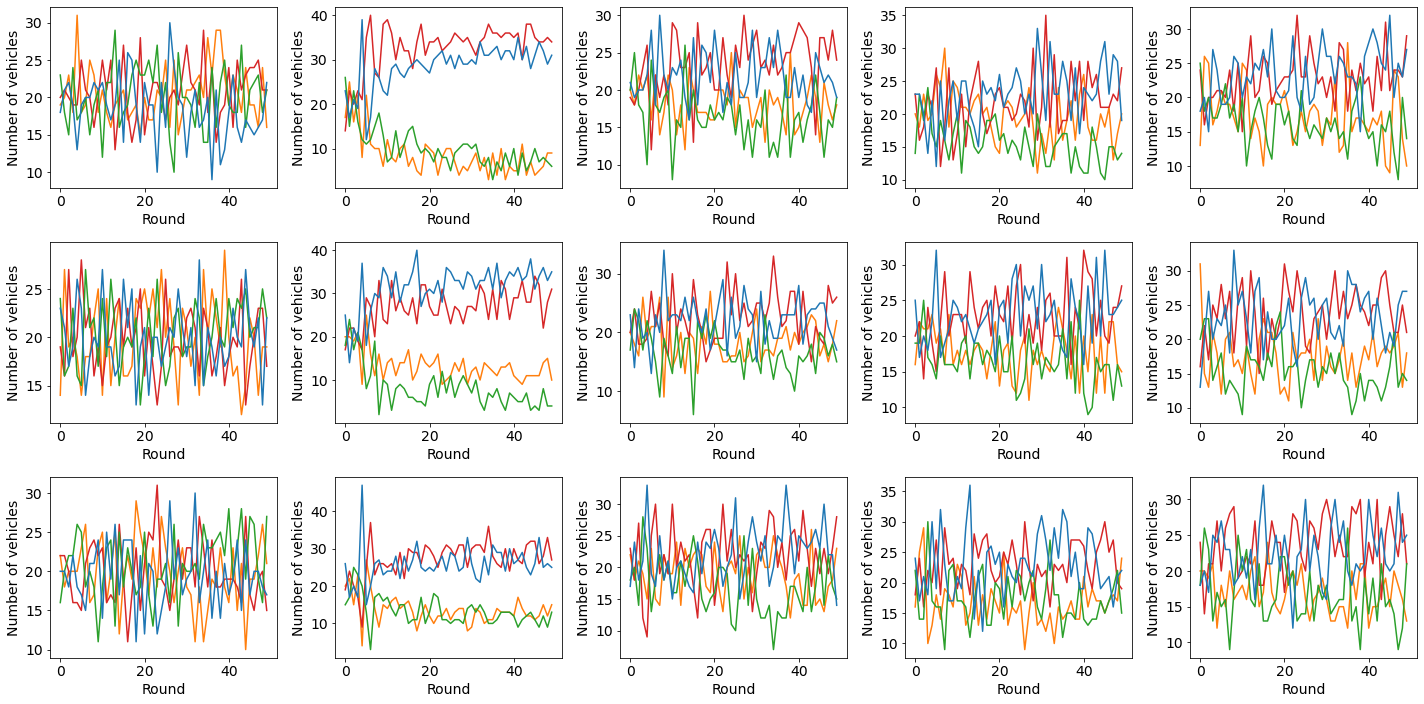

Visualization of Average probability by route for Large alpha:


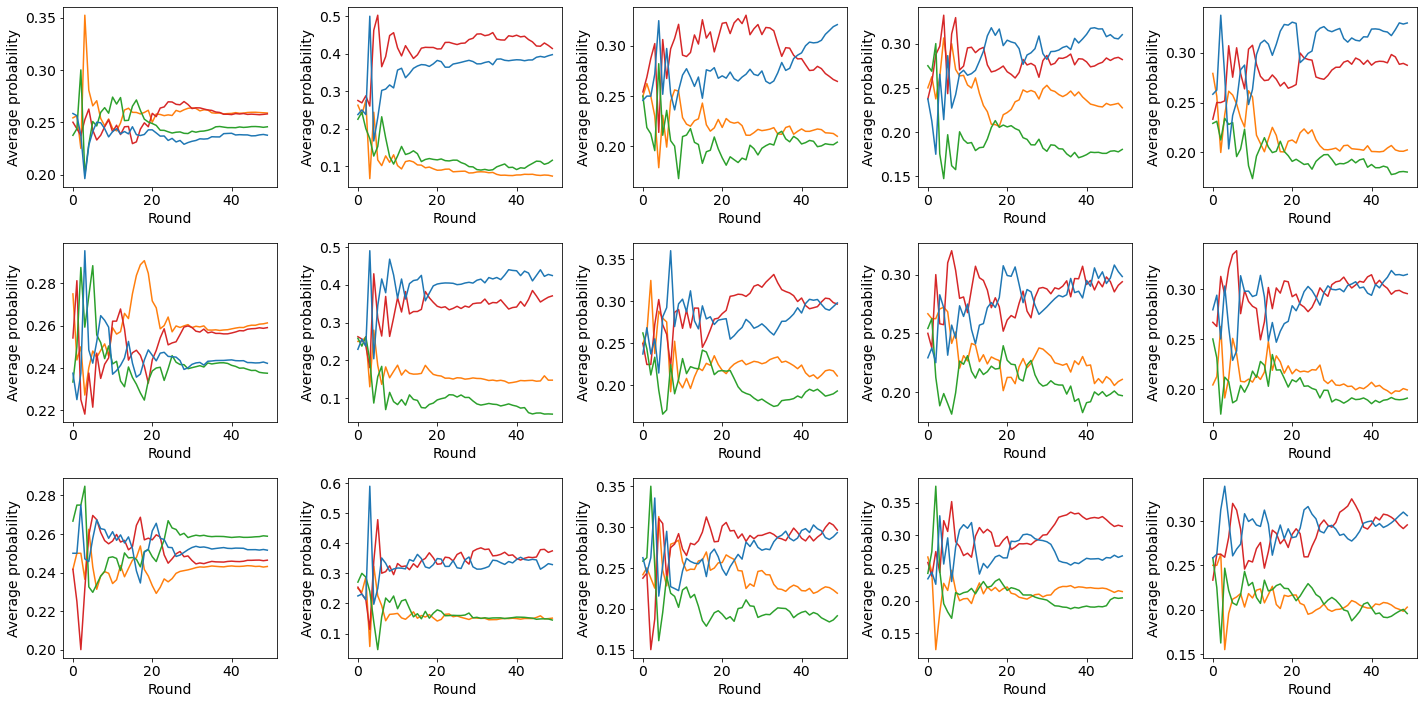

In [39]:
case = case_names[4]
avg_time_by_case(case)
vehicle_num_by_case(case)
avg_prob_by_case(case)

In [40]:
# fig5, axs5 = plt.subplots(row, col, figsize=(width, height))


# for idx in range(len(subfolder_names)):
#     folder = subfolder_names[idx]
    
#     if "No connection" in folder:
#         ax = route_chosen_probability(axs5[idx//col, idx%col], 
#                                       fig5,
#                                       rounds,
#                                       len(sub_routes),
#                                       folder
#                                      )
#     else:
#         ax = route_chosen_probability(axs5[idx//col, idx%col], 
#                                       fig5,
#                                       rounds,
#                                       len(all_routes),
#                                       folder
#                                      )
    
    
#     axs5[idx//col, idx%col] = ax

# plt.tight_layout()
# # plt.savefig("Analysis/Average_probability_by_route.png",
# #             bbox_inches = 'tight', pad_inches=0.25)
# plt.show()

In [41]:
# for idx in range(len(subfolder_names)):
#     folder = subfolder_names[idx]
#     record_df = pd.read_csv(f'{folder}/Saved_data/Simulation_records/Round_{rounds}.csv')
#     record_df = preprocess_record(record_df, all_routes)
    
#     avg_time = avg_total_time(record_df, target_number_of_rounds, rounds)/vehicle_limit
# #     avg_times.append(avg_time/vehicle_limit)
#     sub_name = folder.split('/')[-1]
#     print(f"Folder: {sub_name}\nAvg time: {round(avg_time, 2)}")

In [42]:
# sum(total_utilities)/target_number_of_rounds